# Quantum Teleportation

This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulator to test our quantum circuit, and then try it out on a real quantum computer.

## The concept

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$
to Bob. This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. Copying a state is only possible with a classical computation.

However, by taking advantage of two classical bits and entanglement, Alice can transfer the state $\vert\psi\rangle$ to Bob. We call this teleportation as at the end Bob will have $\vert\psi\rangle$ and Alice won't anymore. Let's see how this works in some detail.

## How does quantum teleportation work?

**Step 1**: Alice and Bob create an entangled pair of qubits and each one of them holds on to one of the two qubits in the pair.

The pair they create is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the Bell basis ($|+\rangle$ and $|-\rangle$) by using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the Bell basis. 

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

**Step 2**: Alice applies a CNOT gate on $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). 

**Step 3**: Next, Alice applies a Hadamard gate to $|\psi\rangle$, and applies a measurement to both qubits that she owns - $q_1$ and $\vert\psi\rangle$.

**Step 4**: Then, it's time for a phone call to Bob. She tells Bob the outcome of her two qubit measurement. Depending on what she says, Bob applies some gates to his qubit, $q_2$. The gates to be applied, based on what Alice says, are as follows :

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

*Note that this transfer of information is classical.*

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

## How will we test this result on a real quantum computer?

In this notebook, we will give Alice a secret state $\vert\psi\rangle$. This state will be generated by applying a series of unitary gates on a qubit that is initialized to the ground state, $\vert0\rangle$. Go ahead and fill in the secret unitary that will be applied to $\vert0\rangle$ before passing on the qubit to Alice.

In [1]:
secret_unitary = 'hz'

If the quantum teleportation circuit works, then at the output of the protocol discussed above will be the same state passed on to Alice. Then, we can undo the applied secret_unitary (by applying its conjugate transpose), to yield the $\vert0\rangle$ that we started with. 

We will then do repeated measurements of Bob's qubit to see how many times it gives 0 and how many times it gives 1.

### What do we expect?

In the ideal case, and assuming our teleportation protocol works, we will always measure 0 from Bob's qubit because we started off with $|0\rangle$.

In a real quantum computer, errors in the gates will cause a small fraction of the results to be 1. We'll see how it looks.

## 1. Simulating the teleportation protocol

In [2]:
# make the imports that are necessary for our work
import qiskit as qk
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit import IBMQ
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [3]:
# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x,
                    'y':quantum_circuit.y,
                    'z':quantum_circuit.z,
                    'h':quantum_circuit.h,                    
                    't':quantum_circuit.t,                    
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg
    
    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]]

In [4]:
# Create the quantum circuit with 3 qubits and 3 classical bits
qc = QuantumCircuit(3, 3)

''' Qubit ordering as follows (classical registers will just contain measured values of the corresponding qubits):
q[0]: qubit to be teleported (Alice's first qubit. It was given to her after the application of a secret unitary 
      which she doesn't know)
q[1]: Alice's second qubit
q[2]: Bob's qubit, which will be the destination for the teleportation
'''

# Apply the secret unitary that we are using to generate the state to teleport. You can change it to any unitary
apply_secret_unitary(secret_unitary, qc.qubits[0], qc, dagger = 0)
qc.barrier()
# Next, generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
qc.h(1)
qc.cx(1, 2)
qc.barrier()
# Next, apply the teleportation protocol. 
qc.cx(0, 1)
qc.h(0)
qc.measure(0, 0)
qc.measure(1, 1)
qc.cx(1, 2)
qc.cz(0, 2)
qc.barrier()

'''
In principle, if the teleportation protocol worked, we have q[2] = secret_unitary|0>
As a result, we should be able to recover q[2] = |0> by applying the reverse of secret_unitary
since for a unitary u, u^dagger u = I.
'''
apply_secret_unitary(secret_unitary, qc.qubits[2], qc, dagger=1)
qc.measure(2, 2)

It's always a good idea to draw the circuit that we have generated in code. Let's draw it below.

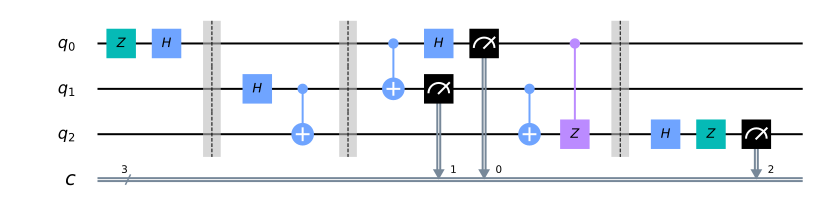

In [5]:
qc.draw(output='mpl')

{'000': 230, '001': 268, '011': 263, '010': 263}


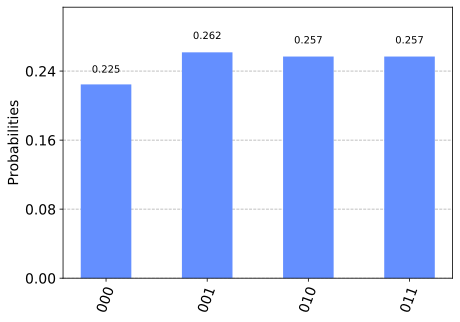

In [6]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

**Note that the results on the x-axis in the histogram above are ordered as $c_2c_1c_0$. We can see that only results where $c_2 = 0$ appear, indicating that the teleporation protocol has worked.**

## 2. Teleportation on a real quantum computer

### 2.1 IBM hardware and Deferred Measurement

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the _deferred measurement principle_[1]. The principle states that any measurement can be postponed until the end of the circuit: We can move all the measurements to the end, and we should see the same results.

Any benefits of measuring early are hardware related: If we can measure early, we may be able to reuse qubits, or reduce the amount of time our qubits are in their fragile superposition. In this example, the early measurement in quantum teleportation would have allowed us to transmit a qubit state without a direct quantum communication channel.

While moving the gates allows us to demonstrate the "teleportation" circuit on real hardware, it should be noted that some of the benefit of the teleportation process is lost. 


In [7]:
# Create the new quantum circuit with 3 qubits and 3 classical bits
qc = QuantumCircuit(3, 3)

''' Qubit ordering as follows (classical registers will just contain measured values of the corresponding qubits):
q[0]: qubit to be teleported (Alice's first qubit. It was given to her after the application of a secret unitary 
      which she doesn't know)
q[1]: Alice's second qubit
q[2]: Bob's qubit, which will be the destination for the teleportation
'''

# Apply the secret unitary that we are using to generate the state to teleport. You can change it to any unitary
apply_secret_unitary(secret_unitary, qc.qubits[0], qc, dagger = 0)
qc.barrier()
# Next, generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
qc.h(1)
qc.cx(1, 2)
qc.barrier()
# Next, apply the teleportation protocol. 
qc.cx(0, 1)
qc.h(0)
qc.cx(1, 2)
qc.cz(0, 2)
apply_secret_unitary(secret_unitary, qc.qubits[2], qc, dagger=1)
# Finally, measure
qc.barrier()
qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

And let's check it looks as expected:

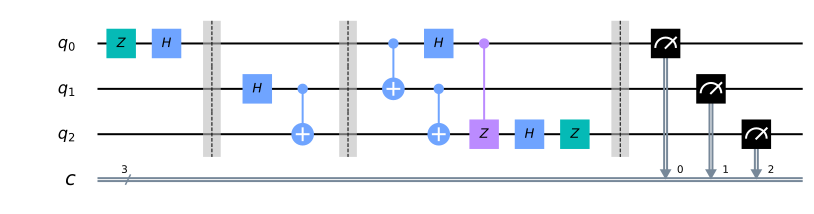

In [8]:
qc.draw(output='mpl')

### 2.2 Executing
You will now see the results of the teleportation algorithm on a real quantum computer. Recall that we need one qubit for $\vert\psi\rangle$, one qubit for Alice, and one qubit for Bob, for a total of three qubits. 

In [9]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

{'110': 188, '100': 464, '001': 1757, '011': 1082, '111': 118, '000': 2268, '010': 1809, '101': 506}


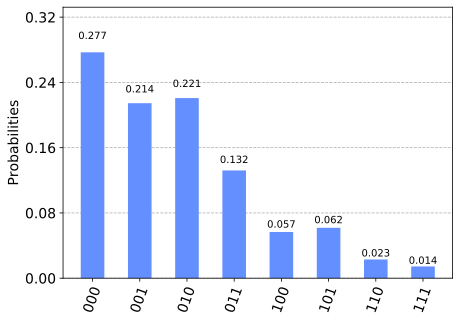

In [10]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(qc, backend=backend, shots=8192)
exp_result = job_exp.result()

exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

As we see here, there are a few results that contain the case when $c_2 = 1$ in a real quantum computer. These arise due to errors in the gates that were applied. In contrast, our simulator in the earlier part of the notebook had zero errors in its gates, and allowed error-free teleportation.

In [11]:
error_rate_percent = sum([exp_measurement_result[result] for result in exp_measurement_result.keys() if result[0]=='1']) \
                    * 100./ sum(list(exp_measurement_result.values()))
print("The experimental error rate : ", error_rate_percent, "%")

The experimental error rate :  15.576171875 %


## 3. References
[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

In [12]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.11.1',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.5',
 'qiskit-aqua': '0.6.2',
 'qiskit': '0.14.1'}